In [2]:
### import libraries

# format
import pandas as pd

# plot
import matplotlib.pyplot as plt
import seaborn as sns

# math
import numpy as np
import math
from scipy.linalg import inv, det
from numpy.linalg import eig

from scipy import stats


In [4]:

data_raw = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv")
data_raw.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [5]:
### Preprocess Data
data = data_raw.copy()

rename_dict = {
    'Person ID':'person_id',
    'Gender': 'gender',
    'Age':'age',
    'Occupation':'occupation',
    'Sleep Duration':'sleep_duration',
    'Quality of Sleep':'quality_of_sleep',
    'Physical Activity Level':'physical_activity_level',
    'Stress Level':'stress_level',
    'BMI Category':'bmi_category', 
    'Blood Pressure':'blood_pressure', 
    'Heart Rate':'heart_rate', 
    'Daily Steps':'daily_steps',
    'Sleep Disorder':'sleep_disorder' 
}

data.rename(columns=rename_dict, inplace=True)

#sleep quality categorical,stress level bmi sleep disorder change to 1 to 0 if there's any sleep issue

data['quality_of_sleep'] = data['quality_of_sleep'].astype(str)
data['stress_level'] = data['stress_level'].astype(str)
data['sleep_issue'] = data['sleep_disorder'].map(lambda x: '1' if x in ['Insomnia','Sleep Apnea'] else '0').astype(str)
data[["blood_pressure_systolic","blood_pressure_diastolic"]] = data["blood_pressure"].str.split('/',expand=True)
data["blood_pressure_diastolic"] = pd.to_numeric(data['blood_pressure_diastolic'])
data["blood_pressure_systolic"] = pd.to_numeric(data["blood_pressure_systolic"])


data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   person_id                 374 non-null    int64  
 1   gender                    374 non-null    object 
 2   age                       374 non-null    int64  
 3   occupation                374 non-null    object 
 4   sleep_duration            374 non-null    float64
 5   quality_of_sleep          374 non-null    object 
 6   physical_activity_level   374 non-null    int64  
 7   stress_level              374 non-null    object 
 8   bmi_category              374 non-null    object 
 9   blood_pressure            374 non-null    object 
 10  heart_rate                374 non-null    int64  
 11  daily_steps               374 non-null    int64  
 12  sleep_disorder            155 non-null    object 
 13  sleep_issue               374 non-null    object 
 14  blood_pres

In [ ]:
data.columns

In [6]:
numeric_variables = ['age','sleep_duration','physical_activity_level','heart_rate','daily_steps','blood_pressure_systolic','blood_pressure_diastolic']
categorical_variable = ['gender','occupation','quality_of_sleep','stress_level','bmi_category','sleep_issue']

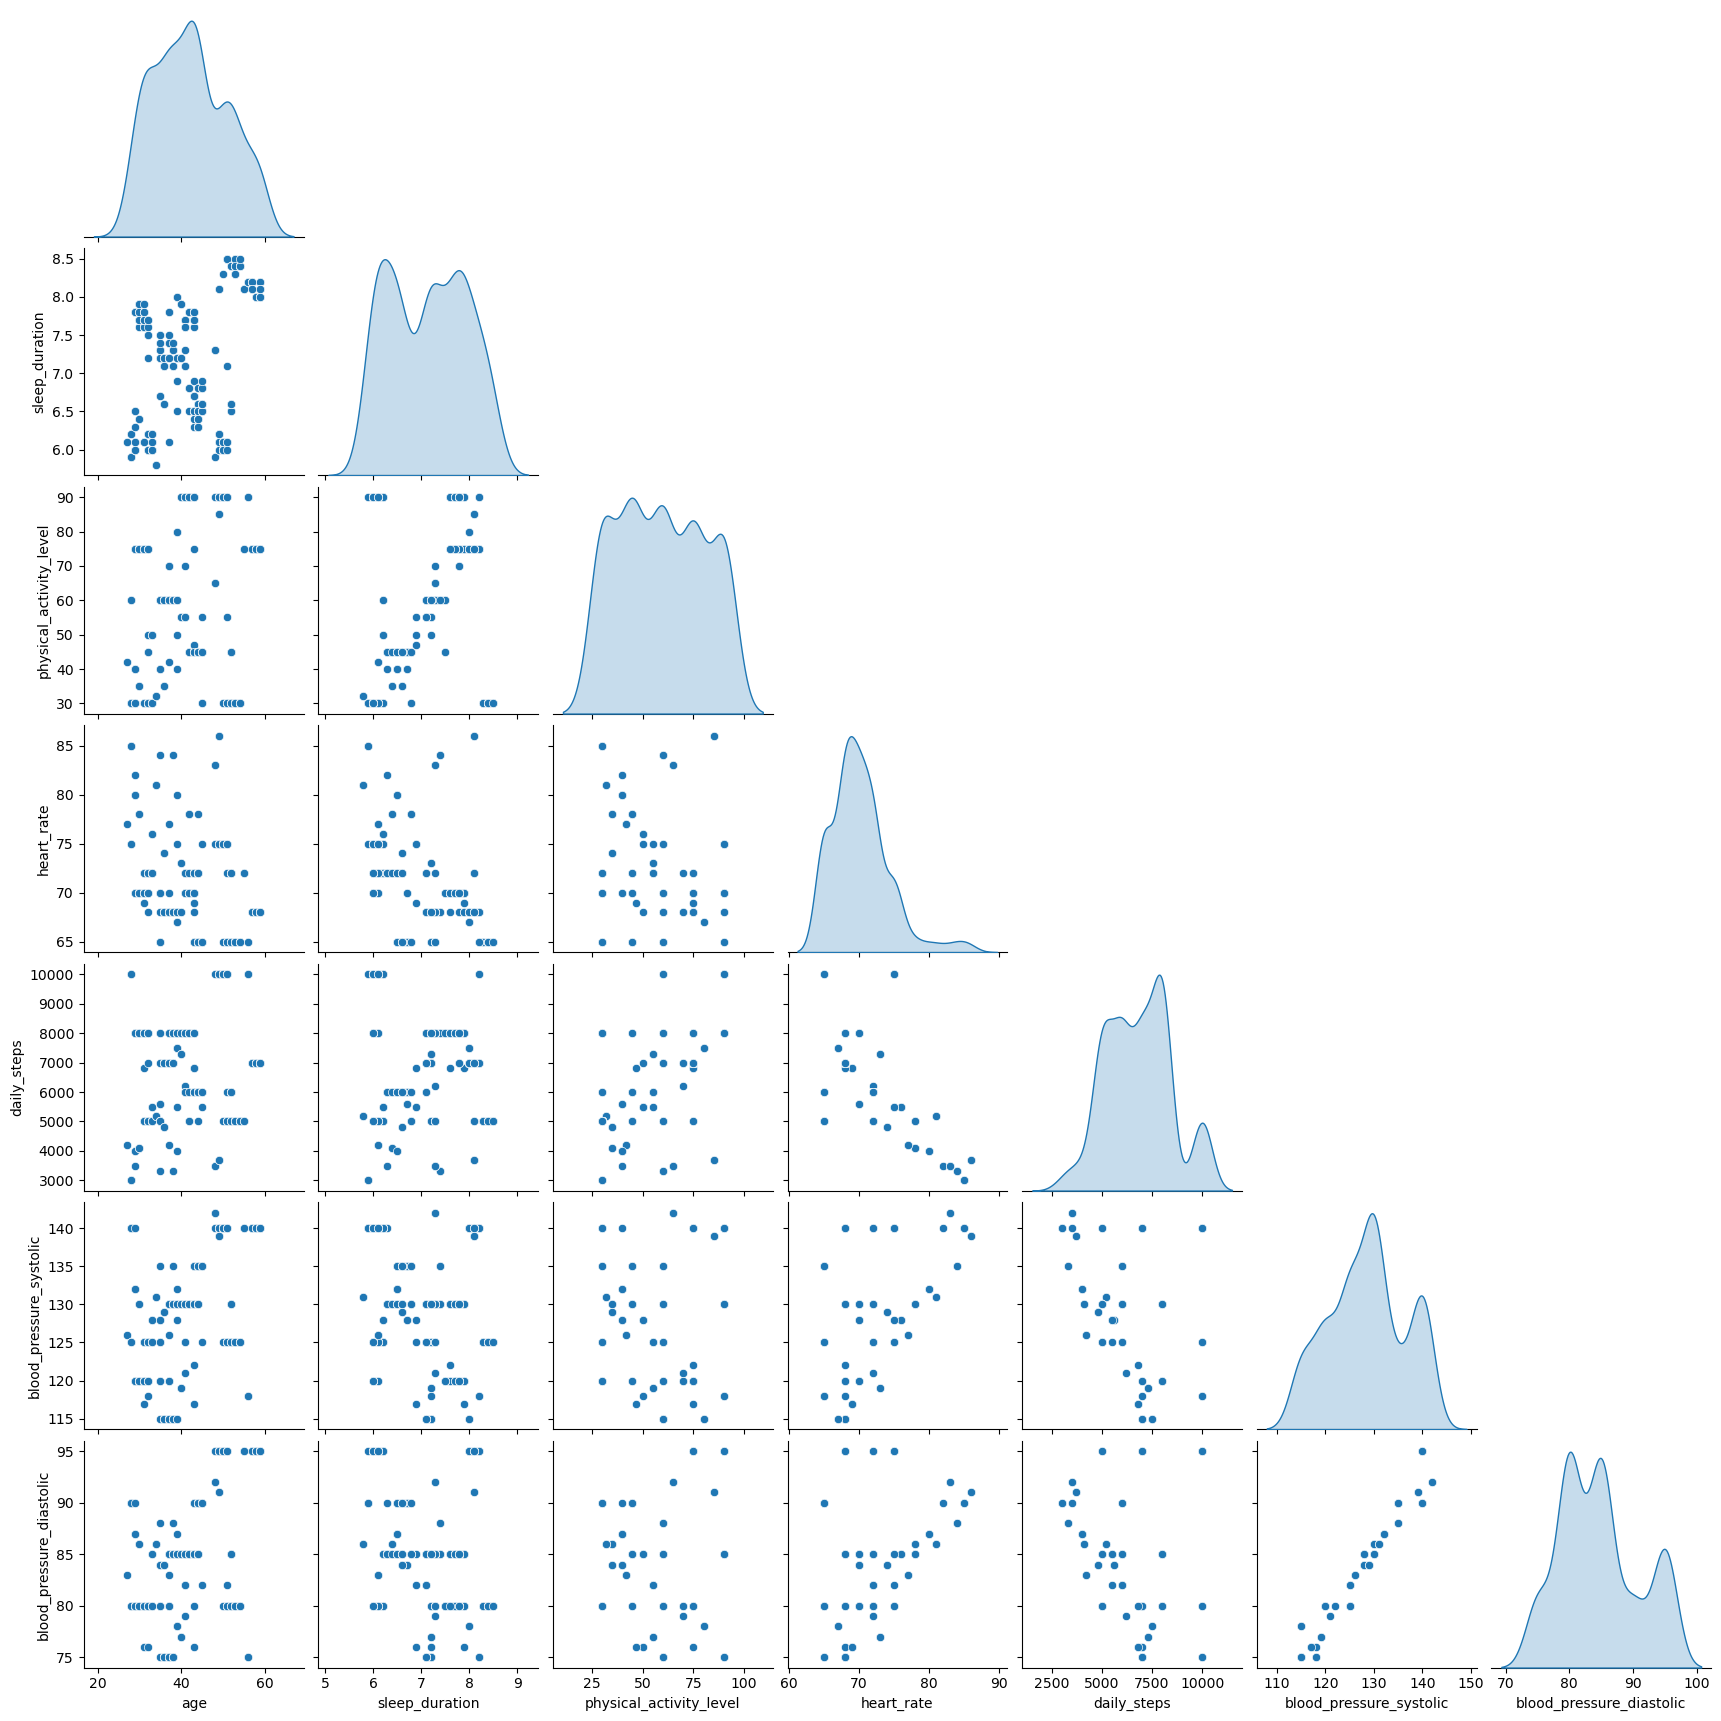

In [7]:
# pairplot
sns.pairplot(data[numeric_variables], diag_kind='kde', corner=True)
plt.show()

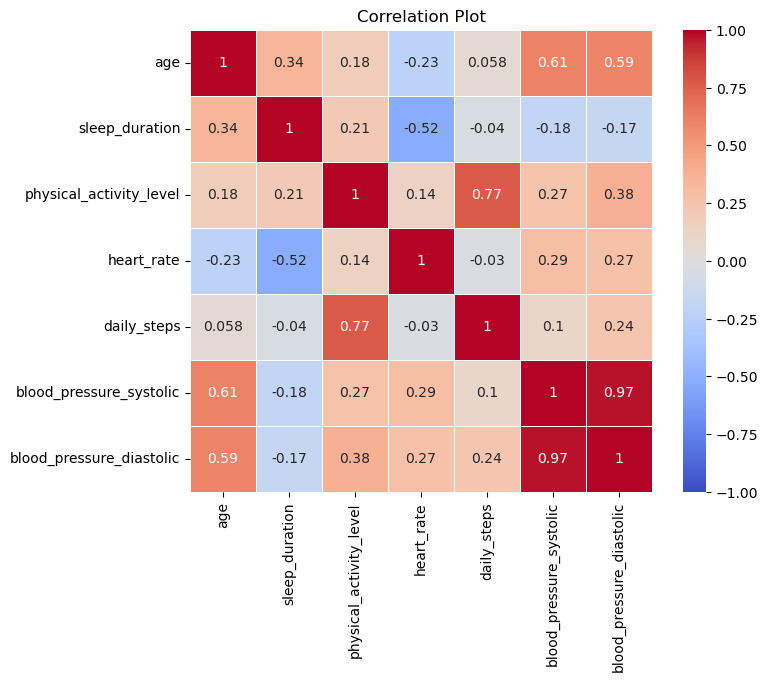

In [8]:
corr_mat = data[numeric_variables].corr()
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, square=True, linewidths=0.5)
plt.title('Correlation Plot')
plt.show()

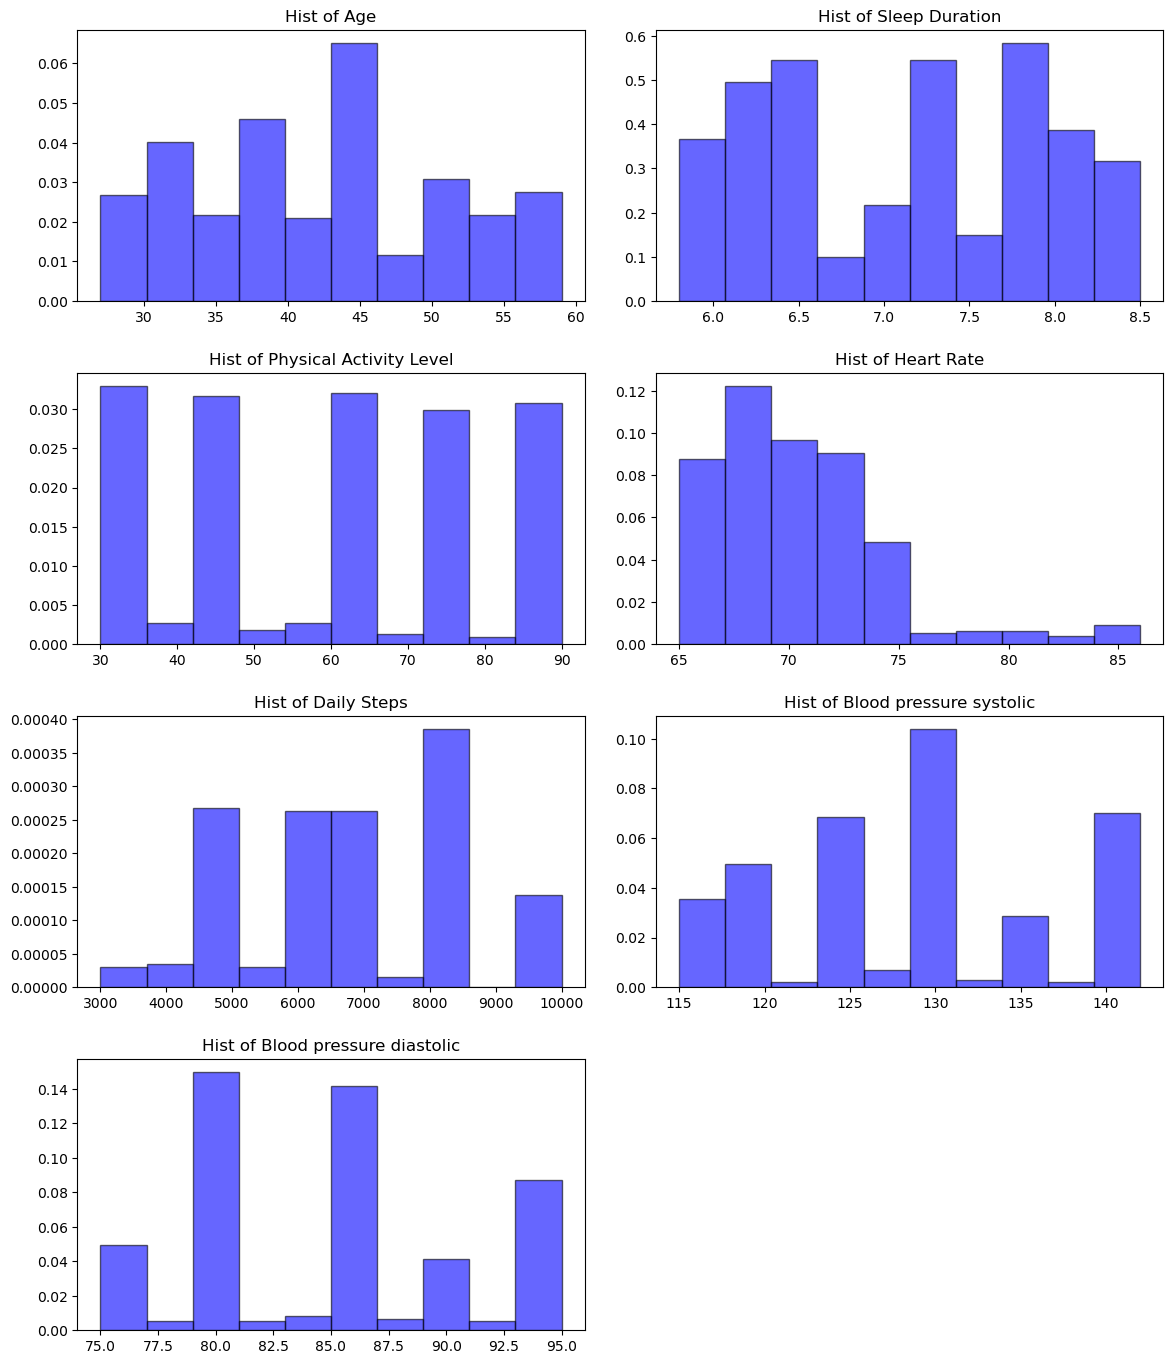

In [18]:

fig, axs = plt.subplots(4,2, figsize=(12, 14))
axs[0,0].hist(data['age'],density=True,alpha=0.6,color='b',edgecolor="black")
axs[0,0].set_title("Hist of Age")
axs[0,1].hist(data['sleep_duration'],density=True,alpha=0.6,color='b',edgecolor="black")
axs[0,1].set_title("Hist of Sleep Duration")
axs[1,0].hist(data['physical_activity_level'],density=True,alpha=0.6,color='b',edgecolor="black")
axs[1,0].set_title("Hist of Physical Activity Level")
axs[1,1].hist(data['heart_rate'],bins=10,density=True,alpha=0.6,color='b',edgecolor="black")
axs[1,1].set_title("Hist of Heart Rate")
axs[2,0].hist(data['daily_steps'],density=True,alpha=0.6,color='b',edgecolor="black")
axs[2,0].set_title("Hist of Daily Steps")
axs[2,1].hist(data['blood_pressure_systolic'],density=True,alpha=0.6,color='b',edgecolor="black")
axs[2,1].set_title("Hist of Blood pressure systolic")
axs[3,0].hist(data['blood_pressure_diastolic'],density=True,alpha=0.6,color='b',edgecolor="black")
axs[3,0].set_title("Hist of Blood pressure diastolic")
axs[3,1].axis("off")
plt.tight_layout(pad=2.0)

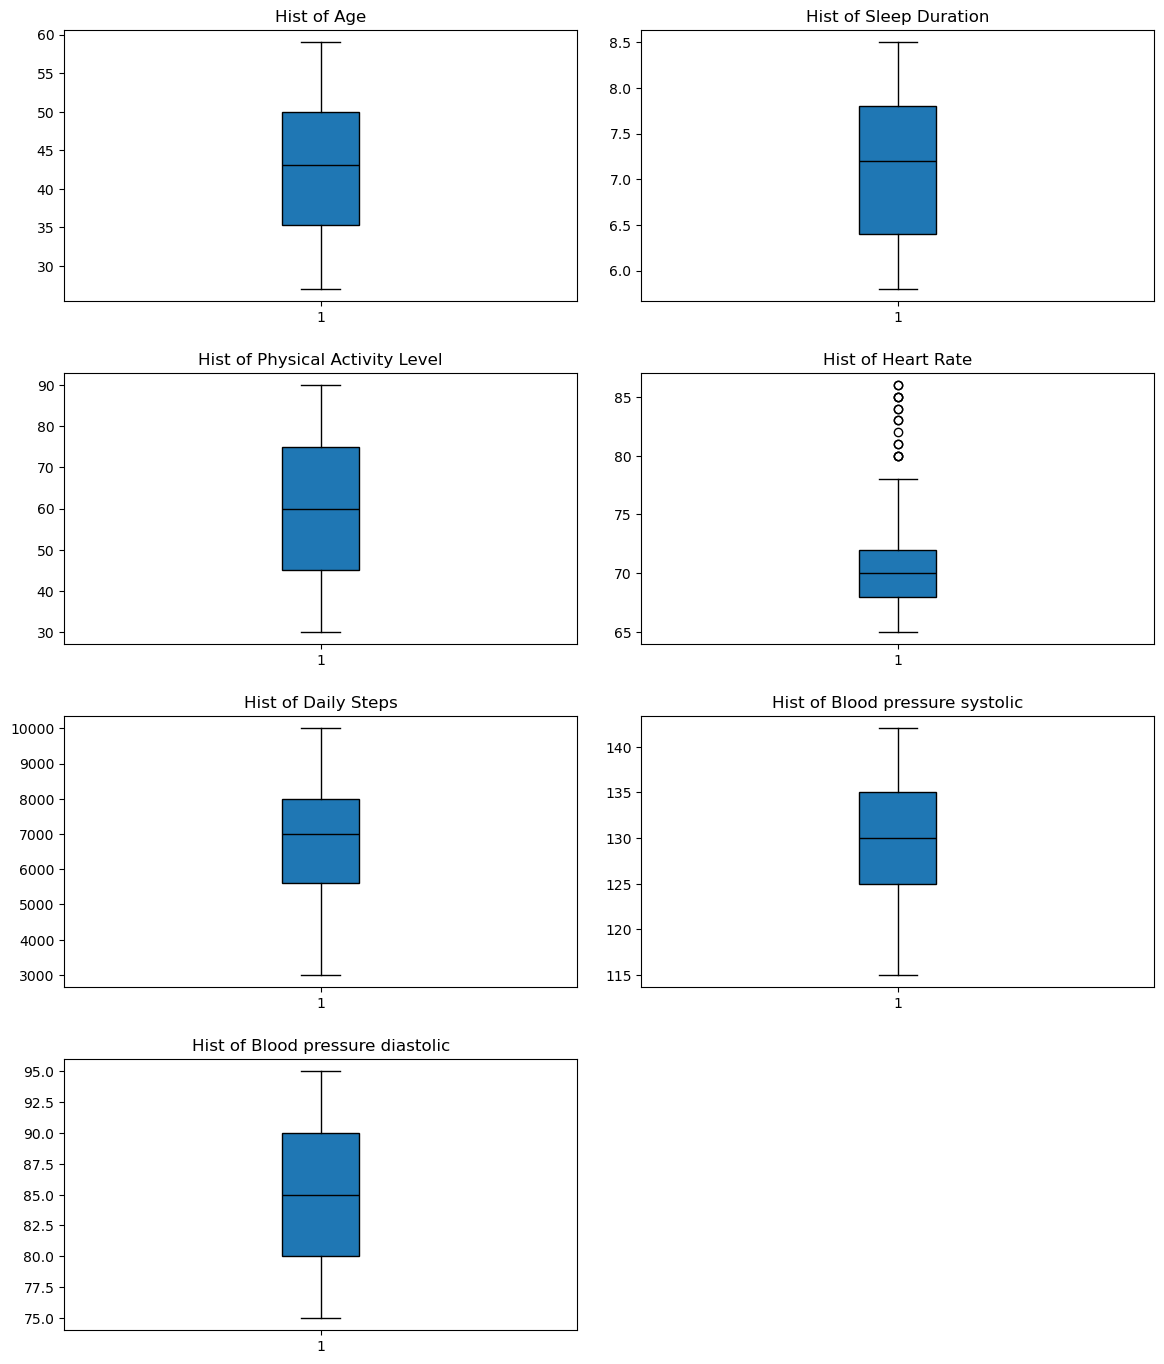

In [19]:

fig, axs = plt.subplots(4,2, figsize=(12, 14))
axs[0,0].boxplot(data['age'],vert=True, patch_artist=True,medianprops=dict(color="black"))
axs[0,0].set_title("Hist of Age")
axs[0,1].boxplot(data['sleep_duration'],vert=True, patch_artist=True,medianprops=dict(color="black"))
axs[0,1].set_title("Hist of Sleep Duration")
axs[1,0].boxplot(data['physical_activity_level'],vert=True, patch_artist=True,medianprops=dict(color="black"))
axs[1,0].set_title("Hist of Physical Activity Level")
axs[1,1].boxplot(data['heart_rate'],vert=True, patch_artist=True,medianprops=dict(color="black"))
axs[1,1].set_title("Hist of Heart Rate")
axs[2,0].boxplot(data['daily_steps'],vert=True, patch_artist=True,medianprops=dict(color="black"))
axs[2,0].set_title("Hist of Daily Steps")
axs[2,1].boxplot(data['blood_pressure_systolic'],vert=True, patch_artist=True,medianprops=dict(color="black"))
axs[2,1].set_title("Hist of Blood pressure systolic")
axs[3,0].boxplot(data['blood_pressure_diastolic'],vert=True, patch_artist=True,medianprops=dict(color="black"))
axs[3,0].set_title("Hist of Blood pressure diastolic")
axs[3,1].axis("off")
plt.tight_layout(pad=2.0)

In [11]:
for i in numeric_variables:
    aux_skew = stats.skew(data[i])
    print(f"Skewness of {i} : {aux_skew}")

Skewness of age : 0.2561893511793312
Skewness of sleep_duration : 0.037403602518975176
Skewness of physical_activity_level : 0.07418782500797434
Skewness of heart_rate : 1.2199056700731632
Skewness of daily_steps : 0.17756151681455
Skewness of blood_pressure_systolic : -0.03552565092220491
Skewness of blood_pressure_diastolic : 0.37705009626387237


[0.948209   0.9115284  0.96033816 0.25164604 0.98831354 0.76247781]


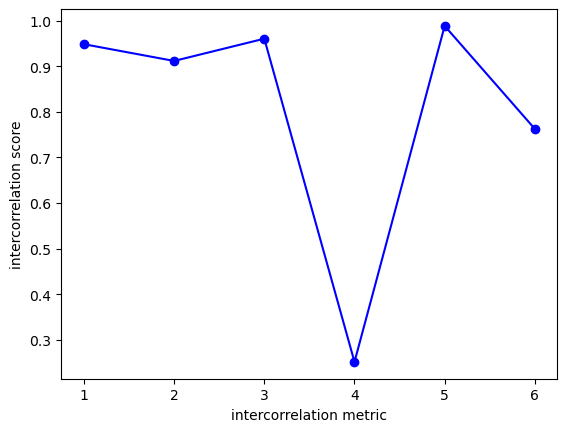

In [12]:
### Statistical Analysis & intercorrelation

means = data[numeric_variables].mean()
variances = data[numeric_variables].var()
df_covariance_matrix = data[numeric_variables].cov()
df_correlation_matrix = data[numeric_variables].corr()

def intercorrelations(X):
    n, p = X.shape
    R = np.corrcoef(X, rowvar=False)
    lambda_vals, _ = eig(R)
    rjj = np.diag(inv(R))
    q = np.zeros(6)
    q[0] = (1 - min(lambda_vals) / max(lambda_vals)) ** (p + 2)
    q[1] = 1 - p / np.sum(1. / lambda_vals)
    q[2] = 1 - np.sqrt(det(R))
    q[3] = (max(lambda_vals) / p) ** (3 / 2)
    q[4] = (1 - min(lambda_vals) / p) ** 5
    q[5] = np.sum((1 - 1. / rjj) / p)
    
    # print
    print(q)

    # plot
    plt.plot(range(1, 7), q, marker='o', linestyle='-', color='b', label='Intercorrelations')
    plt.xlabel("intercorrelation metric")
    plt.ylabel("intercorrelation score")
    return None


intercorrelations(data[numeric_variables])

In [13]:
# Function for plotting of conditional histograms 
def plot_categorical_hist(ncols,
                          numeric_variables,
                          categorical_variable,
                          host_stat='count',
                          figsize=(12, 10)
                          ):
    
    nrows = math.ceil(len(numeric_variables)/ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    for i, col in enumerate(numeric_variables):
        row = i // 2 
        col_pos = i % 2 
        sns.histplot(data=data, x=col, bins=10,hue=categorical_variable, kde=True, ax=axes[row, col_pos],stat=host_stat)
        axes[row, col_pos].set_title(f'Distribution of {col}')

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

In [14]:
# TODO: Select relevant ones 
for categorical_variable in categorical_variables:
    print(categorical_variable)
    plot_categorical_hist(ncols=2,
                        numeric_variables=numeric_variables,#['calories_burned','session_duration_hrs','fat_percentage','avg_bpm'],
                        categorical_variable=categorical_variable,
                        host_stat='probability',
                        figsize=(12, 20))

NameError: name 'categorical_variables' is not defined

## Outliers

In [16]:
summary_stats = []

for i in numeric_variables:
    # Compute the descriptive statistics using scipy.stats.describe
    description = stats.describe(data[i])
    p90 = np.percentile(data[i], 90)
    p95 = np.percentile(data[i], 95)
    p99 = np.percentile(data[i], 99)

    # Store the results as a dictionary (with variable name as key)
    summary_stats.append({
        'Variable': i,
        'Count': description.nobs,
        'Min': description.minmax[0],
        'Mean': description.mean,
        'Percentile 90%': p90,
        'Percentile 95%': p95,
        'Percentile 99%': p99,
        'Max': description.minmax[1],
        'Variance': description.variance
    })

# Convert the list of dictionaries to a DataFrame for easier display
summary_df = pd.DataFrame(summary_stats)

# Display the summary statistics table
print(summary_df)


                   Variable  Count     Min         Mean  Percentile 90%  \
0                       age    374    27.0    42.184492            54.0   
1            sleep_duration    374     5.8     7.132086             8.2   
2   physical_activity_level    374    30.0    59.171123            90.0   
3                heart_rate    374    65.0    70.165775            75.0   
4               daily_steps    374  3000.0  6816.844920          8000.0   
5   blood_pressure_systolic    374   115.0   128.553476           140.0   
6  blood_pressure_diastolic    374    75.0    84.649733            95.0   

   Percentile 95%  Percentile 99%      Max      Variance  
0            58.0            59.0     59.0  7.522324e+01  
1             8.4             8.5      8.5  6.330696e-01  
2            90.0            90.0     90.0  4.339224e+02  
3            78.0            85.0     86.0  1.710381e+01  
4         10000.0         10000.0  10000.0  2.617651e+06  
5           140.0           140.0    142.0  6

In [21]:
for i in numeric_variables:
    q1 = np.percentile(data[i], 25)
    q3 = np.percentile(data[i], 75)
    RIC = q3 - q1 
    nout = np.sum(data[i] > (q3 + 1.5*RIC))
    print(f"The threshold for {i} upper outliers is  {q3 + 1.5*RIC}")
    print(f" then there are {nout} outliers in this variable, representing the {np.round(nout/374*100,2)} % of the dataset")

The threshold for age upper outliers is  72.125
 then there are 0 outliers in this variable, representing the 0.0 % of the dataset
The threshold for sleep_duration upper outliers is  9.899999999999999
 then there are 0 outliers in this variable, representing the 0.0 % of the dataset
The threshold for physical_activity_level upper outliers is  120.0
 then there are 0 outliers in this variable, representing the 0.0 % of the dataset
The threshold for heart_rate upper outliers is  78.0
 then there are 15 outliers in this variable, representing the 4.01 % of the dataset
The threshold for daily_steps upper outliers is  11600.0
 then there are 0 outliers in this variable, representing the 0.0 % of the dataset
The threshold for blood_pressure_systolic upper outliers is  150.0
 then there are 0 outliers in this variable, representing the 0.0 % of the dataset
The threshold for blood_pressure_diastolic upper outliers is  105.0
 then there are 0 outliers in this variable, representing the 0.0 % of

In [ ]:
# This chunk is almost trash, just checking
data_removed = data[data['heart_rate'] > 78] 
data_removed.head()

,person_id,gender,age,occupation,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,bmi_category,blood_pressure,heart_rate,daily_steps,sleep_disorder,sleep_issue,blood_pressure_systolic,blood_pressure_diastolic
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea,1,140,90
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea,1,140,90
5,6,Male,28,Software Engineer,5.9,4,30,8,Obese,140/90,85,3000,Insomnia,1,140,90
6,7,Male,29,Teacher,6.3,6,40,7,Obese,140/90,82,3500,Insomnia,1,140,90
16,17,Female,29,Nurse,6.5,5,40,7,Normal Weight,132/87,80,4000,Sleep Apnea,1,132,87


In [24]:
# temporary data while we have all the transformations
data_cut = data[data['heart_rate'] < 78] 

# CHECKING SKEWNESS AFTER CUTTING OUTLIERS
for i in numeric_variables:
    aux_skew = stats.skew(data_cut[i])
    print(f"Skewness of {i} : {aux_skew}")

Skewness of age : 0.2536214365138958
Skewness of sleep_duration : 0.007023536147360605
Skewness of physical_activity_level : 0.02433993825963072
Skewness of heart_rate : 0.207482395234077
Skewness of daily_steps : 0.38083630557334486
Skewness of blood_pressure_systolic : 0.01885717428155027
Skewness of blood_pressure_diastolic : 0.4513962755289981
